# Setup Tutorial

In this tutorial, we will go over how to set up a Solver object for generating coupling matrices. In particular, we will dive into the different parameters that affect how closely we approximate exact optimal transport solutions.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you are unsure what some of the notation means throughout the rest of this document, or what we are really trying to accomplish, try reading our optimal transport theory section to get more comfortable.

If you are already comfortable with setting up a Solver object, try moving on to our UGW tutorial, which will ease you into using the tool and give some intuition for how to select different hyperparameters.
```

To start, we will set up some random matrices to align:

In [1]:
from scotplus.solvers import SinkhornSolver
import scanpy as sc
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Helvetica Neue'

# setting up torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

nx, ny, dx, dy = 10, 10, 10, 10

X = torch.rand(nx, dx).to(device)
y = torch.rand(ny, dy).to(device)


Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


### Iterations

Now, we can begin examining the Solver object. First, we will look at how the number of iterations (of BCD and UOT) impact alignment.

When instantiating a Solver object, there are two options for modifying the number of iterations done in approximating the optimal coupling matrices for a given alignment: nits_bcd and nits_uot (and nits_gw, which is specified later in the AGW tutorial). To understand what these do, we have to understand the BCD (block coordinate descent) part of the algorithm, as well as the UOT (unbalanced optimal transport) part. See our theory document for a little more detail on these.

When solving for the optimal coupling matrices, our process begins in either the sample or feature matrix (we start with sample in this code), and begins solving a single, non-co-optimal transport problem on this matrix using an OT algorithm like Sinkhorn. Then, it switches to the other matrix, and does the same. We define a single BCD iteration to be one set of OT iterations on each matrix. So, some OT iterations on the sample matrix, followed by some OT iterations on the feature matrix, would constitute one iteration. The total number of iterations the alignment will run for, not accounting for early stopping, is what we select for nits_bcd.

Within a given BCD iteration, we do the selected OT algorithm on each coupling matrix for a certain number of iterations, or until convergence. nits_uot defines the maximum number of times we iterate this algorithm before switching within the larger BCD process. So, a smaller value for nits_uot leads to faster BCD iterations and more communication between the sample/feature coupling matrices, while a larger one will do the opposite. Let's try out some extreme values just to get a sense of how this works:

In [2]:
scot_sm_uot = SinkhornSolver(nits_uot=1)
pi_samp_sm_uot, _, pi_feat_sm_uot = scot_sm_uot.coot(X, y, eps=1e-3, verbose=True)

Changing alpha to 0, no GW data.
BCD Iteration 1 - Loss: 0.105193, 0.105594
BCD Iteration 2 - Loss: 0.098446, 0.098862
BCD Iteration 3 - Loss: 0.089126, 0.089534
BCD Iteration 4 - Loss: 0.079530, 0.079963
BCD Iteration 5 - Loss: 0.073993, 0.074426
BCD Iteration 6 - Loss: 0.081255, 0.081691
BCD Iteration 7 - Loss: 0.090520, 0.090953
BCD Iteration 8 - Loss: 0.093771, 0.094210
BCD Iteration 9 - Loss: 0.086055, 0.086477
BCD Iteration 10 - Loss: 0.080711, 0.081126
BCD Iteration 11 - Loss: 0.079403, 0.079829
BCD Iteration 12 - Loss: 0.073467, 0.073894
BCD Iteration 13 - Loss: 0.073996, 0.074418
BCD Iteration 14 - Loss: 0.070661, 0.071094
BCD Iteration 15 - Loss: 0.070612, 0.071046


In [3]:
scot_lg_uot = SinkhornSolver(nits_uot=10000) # upper bound; UOT likely converges first
pi_samp_lg_uot, _, pi_feat_lg_uot = scot_lg_uot.coot(X, y, eps=1e-3, verbose=True)

Changing alpha to 0, no GW data.
BCD Iteration 1 - Loss: 0.097210, 0.097649
BCD Iteration 2 - Loss: 0.080799, 0.081259
BCD Iteration 3 - Loss: 0.080798, 0.081259


```{warning}
In this example, we are using the Sinkhorn algorithm to solve for our coupling matrices, which is not the only way to solve this problem! However, we're currently working on a more generic solver that allows you to pass in an OT solver of your choosing, subject to some interface requirements, which we will try to match up with existing OT implementations (e.g., POT).
```

Clearly, the second cell of code takes much longer (total, and per iteration) than the first, as expected. In addition, the first cell requires many more BCD iterations to reach the error tolerance, considering each BCD step is doing a lot less (less nested iterations). We can visualize the different coupling matrices:

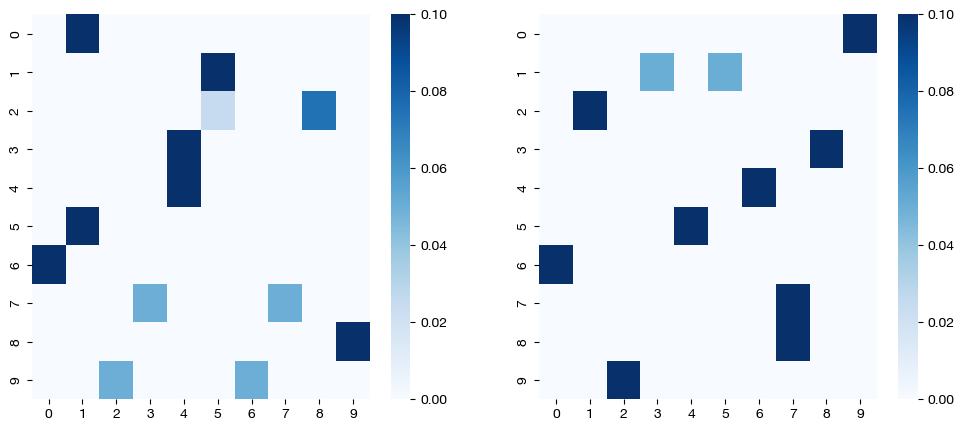

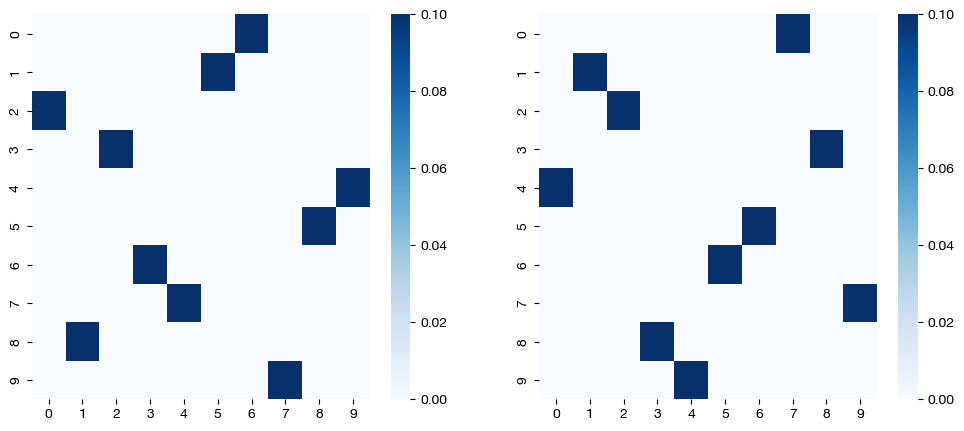

In [4]:
for pi_feat, pi_samp, size in [(pi_feat_sm_uot, pi_samp_sm_uot, 'nits_uot=1'), (pi_feat_lg_uot, pi_samp_lg_uot, 'nits_uot=10000')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pi_feat, ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp, ax=ax2, cmap='Blues')
    plt.show()

Note that the coupling matrices in the first case are not perfectly sparse. We see this result because each individual matrix was not evaluated as much individually (small nits_uot) as they were jointly (normal nits_bcd).

Now, we can find out what happens when we change nits_bcd. The default nits_bcd generally allows for the optimization to continue until it reaches the tolerance; it is not often a limiting factor. However, we can make it a limiting factor by making it small enough, particularly in the case of our small nits_uot from above:

In [34]:
scot_sm_bcd = SinkhornSolver(nits_uot=1, nits_bcd=10)
pi_samp_sm_bcd, _, pi_feat_sm_bcd = scot_sm_bcd.coot(X, y, eps=1e-3, verbose=True)

Changing alpha to 0, no GW data.
BCD Iteration 1 - Loss: 0.128270, 0.131761
BCD Iteration 2 - Loss: 0.083552, 0.087574
BCD Iteration 3 - Loss: 0.076625, 0.080771
BCD Iteration 4 - Loss: 0.076482, 0.080741
BCD Iteration 5 - Loss: 0.074275, 0.078487
BCD Iteration 6 - Loss: 0.073326, 0.077636
BCD Iteration 7 - Loss: 0.071058, 0.075297
BCD Iteration 8 - Loss: 0.078605, 0.082837
BCD Iteration 9 - Loss: 0.075397, 0.079568
BCD Iteration 10 - Loss: 0.070657, 0.074796


In [35]:
scot_lg_bcd = SinkhornSolver(nits_uot=10000, nits_bcd=10)
pi_samp_lg_bcd, _, pi_feat_lg_bcd = scot_lg_bcd.coot(X, y, eps=1e-3, verbose=True)

Changing alpha to 0, no GW data.
BCD Iteration 1 - Loss: 0.117262, 0.120491
BCD Iteration 2 - Loss: 0.075060, 0.079551
BCD Iteration 3 - Loss: 0.074377, 0.078959
BCD Iteration 4 - Loss: 0.074376, 0.078959


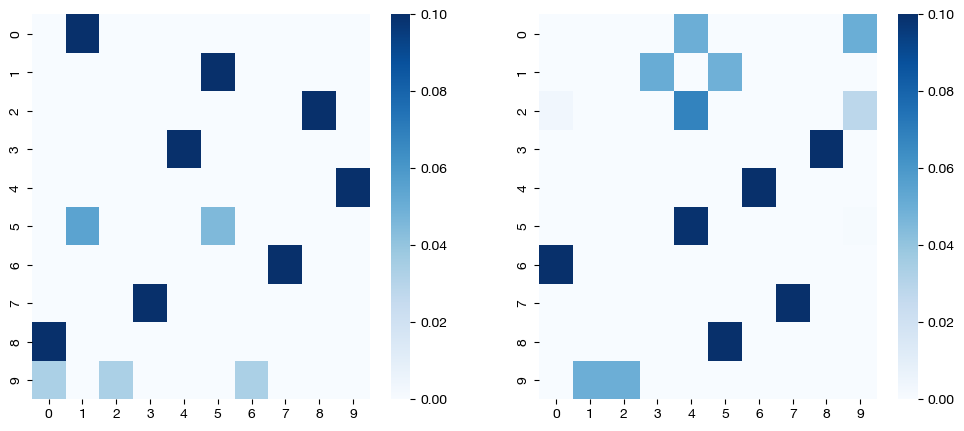

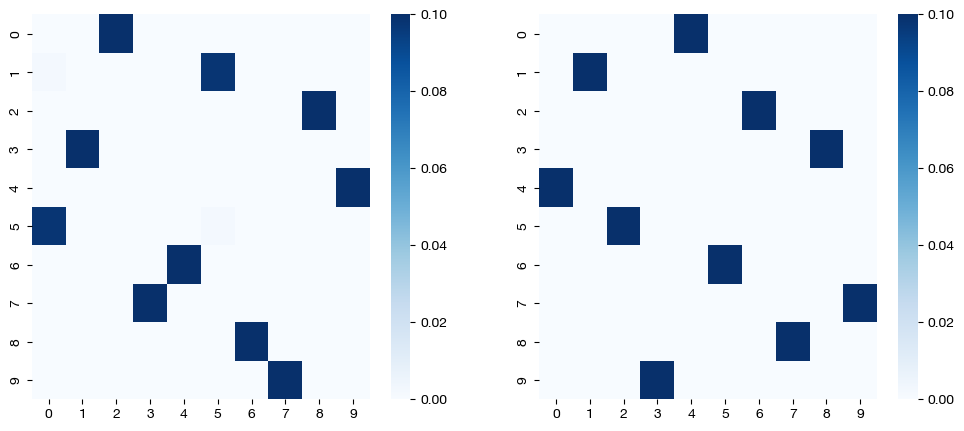

In [36]:
for pi_feat, pi_samp, size in [(pi_feat_sm_bcd, pi_samp_sm_bcd, 'nits_uot=1'), (pi_feat_lg_bcd, pi_samp_lg_bcd, 'nits_uot=10000')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pi_feat, ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp, ax=ax2, cmap='Blues')
    plt.show()

As seen in the matrices above, limiting nits_uot and nits_bcd leads to a lack of convergence to a sparse solution as we would expect from this level of epsilon (see UCOOT/UGW tutorial to learn more about epsilon).

Now that we have an understanding of how these two parameters work, we can make some suggestions. First, we suggest leaving nits_bcd at the default, unless your alignment is going beyond its bound, and you would like to see continued convergence (this will happen in cases where you have a very low error tolerance, which leads to later iterations being less meaningful anyway). For nits_uot, we suggest a little bit more experimentation, although as you can see in these results, allowing for a larger number of iterations leads to more sparse coupling matrices, which may be desirable.

### Evaluation

Now that we understand the iterations parameters, lets move onto the evaluation parameters: eval_uot and eval_bcd. Our understanding of the BCD and UOT processes transfers over to these parameters. In particular, eval_uot and eval_bcd determine how often the error of each process is calculated. For example, if we set eval_uot=5, the error of the given OT algorithm will be calculated every 5 iterations. We can see how this looks by modifying eval_bcd and seeing what the cost log looks like. We will lower nits_uot and raise nits_bcd to make the difference more clear:

In [23]:
scot_sm_eval = SinkhornSolver(nits_bcd=100, eval_bcd=1, nits_uot=1)
(pi_samp_sm_eval, _, pi_feat_sm_eval), _, log_ent_cost = scot_sm_eval.coot(X, y, eps=1e-3, verbose=False, log=True)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 73


In [24]:
scot_lg_eval = SinkhornSolver(nits_bcd=100, eval_bcd=50, nits_uot=1)
(pi_samp_lg_eval, _, pi_feat_lg_eval), _, log_ent_cost = scot_lg_eval.coot(X, y, eps=1e-3, verbose=False, log=True)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 3


```{note}
eval_bcd, as seen above, does affect the actual alignment. We will see exactly why in the next section; however, the basic idea is that once the optimization hits a certain convergence threshold, it will stop. Since we only evaluate this convergence threshold every eval_bcd iterations, then if eval_bcd is a large, we might hit the threshold, but continue running BCD until we reach the next "eval" iteration. This is why we see more iterations in the second cell above; it would have stopped closer to 73 if eval_bcd were smaller. Instead, it was forced to continue to iteration 101.
```

Since eval_uot is almost entirely under the hood, we will not look at a code example. However, it functions the same as eval_bcd, except on the inner OT processes. The only reason to raise eval_uot above 1 is if you believe your coupling matrix will take a long time to converge and thus want to save a little bit of time by evaluating error less frequently.

Clearly, the two evaluation parameters are slightly more important in conjunction with the tolerance parameters we will now examine. Note, in addition to the total transport cost being printed on the screen, we also evaluate the error in terms of how far away the previous iteration is from the current iteration under the hood, both in terms of cost and in terms of the products themselves (i.e. UGW(pi) - UGW(pi_prev), but also pi - pi_prev, in a sense). We call these types of errors "differential error" in the next section.

### Tolerance

From here, we will move on to another two parameters: tol_bcd and tol_uot. Rather than determining how many iterations each process does, tol_bcd and tol_uot determine when these processes might be allowed to stop before reaching their iteration count. The iterations (nits_bcd and nits_uot) are an upper bound of how long the processes are allowed to run; in some cases, the tolerance will be reached first. Recall that the tolerance is only checked at every eval iteration; so, if the error tolerance is achieved at a non-eval iteration and then deviates by the time it reaches an eval iteration, the process would still continue.

```{warning}
Note that the tolerance we specify with these parameters relates to the "differential error" of the matrices themselves (i.e., pi - pi_prev), NOT the optimal transport cost you see printed when running an optimization in verbose mode. So, the tolerance you specify will determine, in a sense, how close two iterations have to be to claim that the matrices (or duals) have "converged."

In order to specify a tolerance on the optimal transport cost "differential error", use the early_stopping_tol parameter of any of the SCOT+ alignment methods. Since the absolute size of the cost will vary based on hyperparameters and the nature of your datasets, early_stopping_tol should be adjusted carefully (which is why we require it on a per-alignment basis, rather than in setup)
```

If we make either tolerance too high, the processes will stop before converging at all and give us an unreasonable solution. However, if we make either tolerance too low, we might have to wait until exhausting the iteration count, rather than getting an early exit. Let's start with too high:

In [37]:
scot_lg_tol = SinkhornSolver(nits_uot=1, tol_bcd=100)

# note early_stopping_tol is like tolerance, but for differential UCOOT cost, not the matrices themselves
(pi_samp_lg_tol, _, pi_feat_lg_tol), _, log_ent_cost = scot_lg_tol.coot(X, y, eps=1e-3, verbose=False, log=True, early_stopping_tol=0)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 2


If we had let the tolerance be less, we would have seen many more iterations:

In [38]:
scot_lg_tol = SinkhornSolver(nits_uot=1, tol_bcd=0.1)
(pi_samp_lg_tol, _, pi_feat_lg_tol), _, log_ent_cost = scot_lg_tol.coot(X, y, eps=1e-3, verbose=False, log=True, early_stopping_tol=0)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 16


But, if we had let it be too low, we would have seen the iterations run out first:

In [39]:
scot_lg_tol = SinkhornSolver(nits_uot=1, tol_bcd=1e-10, nits_bcd=150)
(pi_samp_lg_tol, _, pi_feat_lg_tol), _, log_ent_cost = scot_lg_tol.coot(X, y, eps=1e-3, verbose=False, log=True, early_stopping_tol=0)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 151


Given this demonstration, you can either choose tolerance to be 0 to force all of your iterations to run, or you might give it a reasonable (small) value to stop the iterations once convergence has sufficiently slowed.

As in the last section, tol_uot is largely under the hood, so we will only look at one code example. However, the same ideas apply; if tol_uot is small, each OT process (in the larger scheme of the BCD iterations) will run for all nits_uot iterations. If tol_uot is large, the OT processes will not converge, leading to dense/inaccurate coupling matrices:

In [53]:
# notice that we use default nits_uot; an nits_uot of 1 is just as bad as a high tol_uot
scot_lg_ot_tol = SinkhornSolver(tol_uot=100)
(pi_samp_lg_ot_tol, _, pi_feat_lg_ot_tol), _, log_ent_cost = scot_lg_ot_tol.coot(X, y, eps=1e-3, verbose=False, log=True)
print("Number of cost calculations: {0}".format(len(log_ent_cost)))

Changing alpha to 0, no GW data.
Number of cost calculations: 16


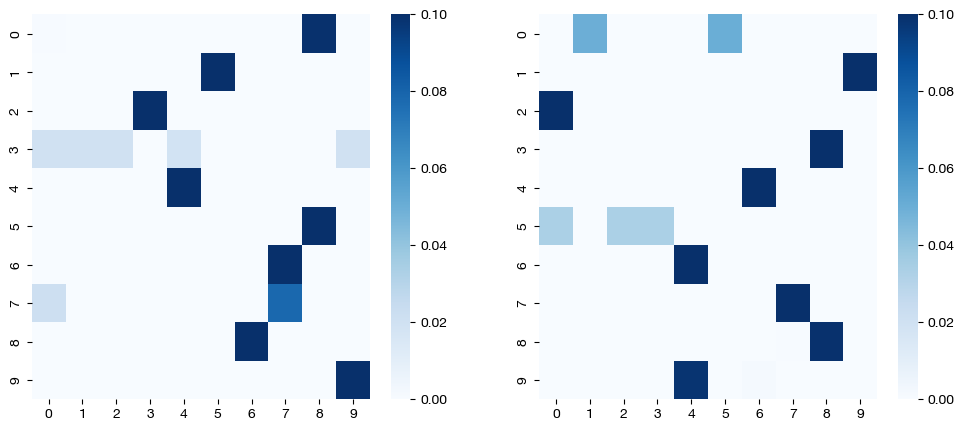

In [54]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(pi_feat_lg_ot_tol, ax=ax1, cmap='Blues')
sns.heatmap(pi_samp_lg_ot_tol, ax=ax2, cmap='Blues')
plt.show()

Here, we see a similar result as when we limited nits_uot in the first section, which is consistent, since our high tol_uot is roughly equivalent (in practice) to nits_uot = 1.

```{note}
In the future, we plan on extending the SinkhornSolver interface to support other OT solutions for the blocks within each BCD iteration. This new form of solver will share a similar convergence hyperparameter interface.
```

Hopefully, with this tutorial completed, you now understand how to set up a Solver object to run your various alignments with UCOOT or UGW. Our defaults should be appropriate for most cases, but feel free to play around with the parameters to get more convergence or more frequent tradeoffs between optimizing the two coupling matrices in the UCOOT case. We now recommend continuing on to the UCOOT/UGW tutorials in order to begin really using SCOT+.

Citations:

Quang Huy Tran, Hicham Janati, Nicolas Courty, Rémi Flamary, Ievgen Redko, Pinar Demetci and Ritambhara Singh. Unbalanced CO-Optimal Transport. arXiv, stat.ML, 2023.